# Astrophysics Laboratory: Data analysis - Stellar clusters
## M71 Data:

### Master bias creation

In [1]:
from helper_functions import masterBiasCreator

dir_bias   = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibration_Images/"
dir_saves  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Calibration_Frames/"
masterBias = masterBiasCreator(dir_bias, False, dir_saves, silent = True)

### Master flat (Red, Green, Blue) creation

In [2]:
from helper_functions import masterFlatCreator

dir_flats       = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibration_Images/"
dir_saves       = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Calibration_Frames/"
masterFlatRed   = masterFlatCreator(masterBias, dir_flats, False, dir_saves, "Red", silent = True) # ; print()
masterFlatGreen = masterFlatCreator(masterBias, dir_flats, False, dir_saves, "Green", silent = True) # ; print()
masterFlatBlue  = masterFlatCreator(masterBias, dir_flats, False, dir_saves, "Blue", silent = True)

### Image calibration

In [3]:
from helper_functions import generateCalibratedFrames

dir_lights  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/All_Images/"
dir_saves   = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibrated_Images/"
generateCalibratedFrames(masterBias, masterFlatRed, dir_lights, dir_saves, "Red", silent = True)# ; print()
generateCalibratedFrames(masterBias, masterFlatGreen, dir_lights, dir_saves, "Green", silent = True)# ; print()
generateCalibratedFrames(masterBias, masterFlatBlue, dir_lights, dir_saves, "Blue", silent = True)

### Alignment of individual colours using `astroalign`

In [4]:
from helper_functions import align_colour_frames

light_dir = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibrated_Images/"
saves_dir = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"

align_colour_frames(light_dir, saves_dir, "Red", silent = True)
align_colour_frames(light_dir, saves_dir, "Green", silent = True)
align_colour_frames(light_dir, saves_dir, "Blue", silent = True)

### Stacking of individual colours

In [5]:
from helper_functions import stack_colour_frames

dir_lights  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"
dir_saves   = dir_lights

_ = stack_colour_frames(dir_lights, dir_saves, 'Red', silent = True, plot_flag = False)
_ = stack_colour_frames(dir_lights, dir_saves, 'Green', silent = True, plot_flag = False)
_ = stack_colour_frames(dir_lights, dir_saves, 'Blue', silent = True, plot_flag = False)

### Alignment of the three resulting stacked light frames (R, G, B)

In [4]:
from helper_functions import align_3_stacked

dir_lights  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"
dir_saves   = dir_lights

align_3_stacked(dir_lights, dir_saves, silent = True)

### Running *'Starfinder'* algorithms

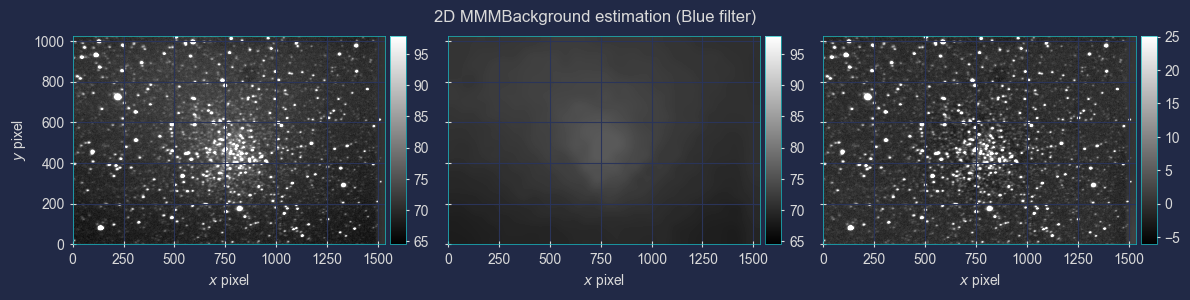

Obtained FWHM values: xfwhm = 7.991062618345857, yfwhm = 9.789677060131888.
Found 944 stars in image (Blue filter).


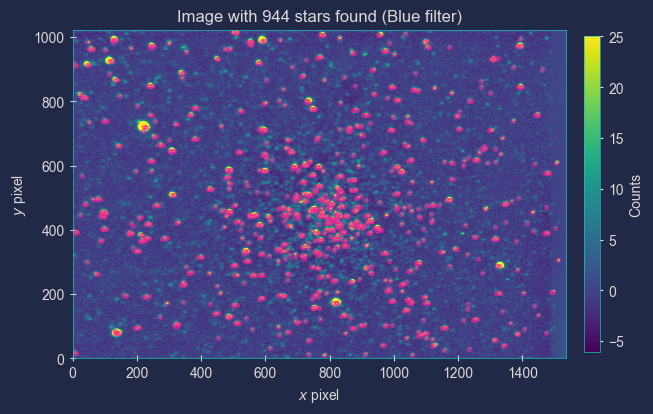

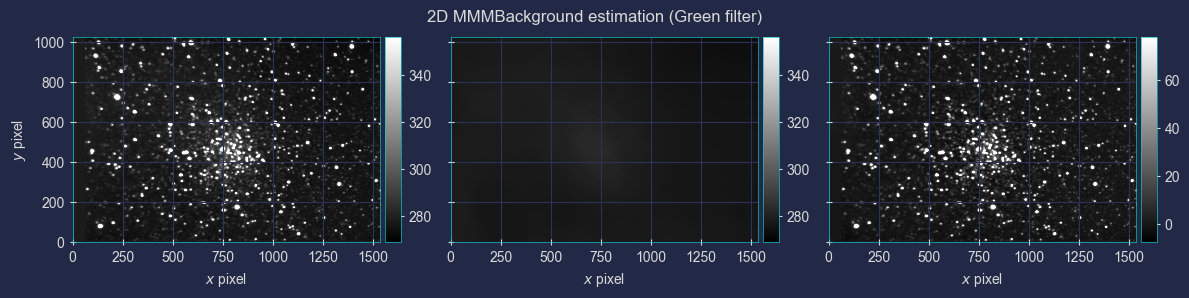

Obtained FWHM values: xfwhm = 7.287064036070989, yfwhm = 7.496357693463297.
Found 783 stars in image (Green filter).


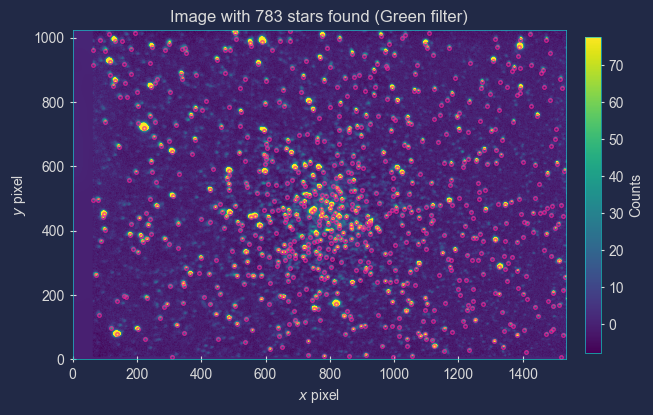

In [11]:
from helper_functions import *

dir_lights       = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"
blue_frame_data  = fits.open(dir_lights + "Blue_Stacked_Aligned.fits")[0].data
green_frame_data = fits.open(dir_lights + "Green_Stacked_Aligned.fits")[0].data

blue_table  = CreateStarsTable(blue_frame_data, iterative = True, filter = "Blue", exp_time = 90.0, plot_bkg_flag = True, \
                              plot_stars_flag = True, fit_shape = (9, 9), threshold_sig = 10.0, aperture_radius = 12.0, \
                              grouper_dist = 15.0, model_2D = True, silent = False)

green_table = CreateStarsTable(green_frame_data, iterative = False, filter = "Green", exp_time = 60.0, plot_bkg_flag = True, \
                              plot_stars_flag = True, fit_shape = (9, 9), threshold_sig = 10.0, aperture_radius = 12.0, \
                              grouper_dist = 15.0, model_2D = True, silent = False)

Results - Blue filter:
- 468 stars (Symmetric gaussian model, **not** iterative);
- 478 stars (2D Assymetric gaussian model, **not** iterative).
- 921 stars (Symmetric gaussian model, **iterative**).
- 944 stars (2D Assymetric gaussian model, **iterative**).

TODO:
- Should exclude the ones in the outskirts -> These fits are not meaningful! (I've excluded the ones outside the grid, but not yet those in the `bad` alignment regions.);

Note that this H-R diagram might need to be corrected for the distance later (so we have absolute magnitudes, instead of apparent ones).

452 matches found.


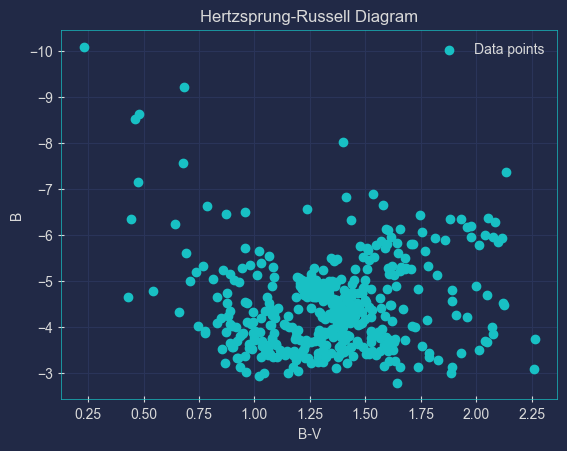

In [15]:
from helper_functions import *

BV_List = GenerateHR(blue_table, green_table, match_dist = 1.0, silent = True)